In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
# import mysql.connector
# from sqlalchemy import create_engine
# import time
# from wordcloud import WordCloud
# !pip install pymysql

# # Establish connection to MySQL database
# engine = create_engine("mysql+pymysql:  d

# # Function to fetch all data from results_table
# def fetch_data():
#     query = "SELECT * FROM results_table"
#     omega_pd = pd.read_sql(query, engine)
#     return omega_pd

# spark = SparkSession.builder.getOrCreate()
# # Fetch data from the database
# omega_pd = fetch_data()
# omega_raw = spark.createDataFrame(omega_pd)

In [99]:
#### Convert json into df
omega_raw = pd.read_json('listen_events.json', lines=True)

#### Divide duration seconds into minutes

omega_raw['duration'] = omega_raw['duration'] 60
omega_raw['duration'] = omega_raw['duration'].round()

#### Make ts smaller
omega_raw['ts'] = omega_raw['ts'].astype(str)
omega_raw['ts'] = omega_raw['ts'].str[7:12]
omega_raw['ts'] = omega_raw['ts'].astype(int)

#### Add Month to Omega because we cant replace the ints with strings, so add new col.
omega_raw['month'] = ''

omega_raw.loc[omega_raw['ts'] < 8333, 'month'] = 'January'
omega_raw.loc[(omega_raw['ts'] > 8333) & (omega_raw['ts']< 16666), 'month'] = 'February'
omega_raw.loc[(omega_raw['ts'] > 16666) & (omega_raw['ts']< 25000), 'month'] = 'March'
omega_raw.loc[(omega_raw['ts'] > 25000) & (omega_raw['ts']< 33333), 'month'] = 'April'
omega_raw.loc[(omega_raw['ts'] > 33333) & (omega_raw['ts']< 41666), 'month'] = 'May'
omega_raw.loc[(omega_raw['ts'] > 41666) & (omega_raw['ts']< 50000), 'month'] = 'June'
omega_raw.loc[(omega_raw['ts'] > 50000) & (omega_raw['ts']< 58333), 'month'] = 'July'
omega_raw.loc[(omega_raw['ts'] > 58333) & (omega_raw['ts']< 66666), 'month'] = 'August'
omega_raw.loc[(omega_raw['ts'] > 66666) & (omega_raw['ts']< 75000), 'month'] = 'September'
omega_raw.loc[(omega_raw['ts'] > 75000) & (omega_raw['ts']< 83333), 'month'] = 'October'
omega_raw.loc[(omega_raw['ts'] > 83333) & (omega_raw['ts']< 91666), 'month'] = 'November'
omega_raw.loc[(omega_raw['ts'] > 91666) & (omega_raw['ts']< 99999), 'month'] = 'December'

#### Refine userAgent into easier to read values

omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'Windows' if 'Windows' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'iPad' if 'iPad' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'iPhone' if 'iPhone' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'Linux' if 'X11' in x else x)
omega_raw['userAgent'] = omega_raw['userAgent'].apply(lambda x: 'Mac' if 'Macintosh' in x else x)

#### Remove unused Cols

omega_raw.drop('lon', axis=1, inplace=True)
omega_raw.drop('lat', axis=1, inplace=True)
omega_raw.drop('auth', axis=1, inplace=True)
omega_raw.drop('registration', axis=1, inplace=True)
omega_raw.drop('lastName', axis=1, inplace=True)
omega_raw.drop('itemInSession', axis=1, inplace=True)
omega_raw.drop('zip', axis=1, inplace=True)
omega_raw.drop('city', axis=1, inplace=True)

In [100]:
#### establish timezones
est=["ME","NH","VT","MA","RI","CT","NY","NJ","PA","DE","MD","DC","VA","NC","SC","GA","FL","KY","WV","OH","IN","MI"]
cst=["WI","IL","TN","AL","MS","LA","AR","MO","IA","MN","ND","SD","NE","KS","OK","TX"]
mst=["NM","CO","WY","MT","ID","UT","AZ"]
pst=["CA","WA","OR","NV"]
hast=["AK","HI"]


In [101]:
#### Refine Data into timezones
est_df = omega_raw[omega_raw['state'].isin(est)]
cst_df = omega_raw[omega_raw['state'].isin(cst)]
mst_df = omega_raw[omega_raw['state'].isin(mst)]
pst_df = omega_raw[omega_raw['state'].isin(pst)]
hast_df = omega_raw[omega_raw['state'].isin(hast)]

In [103]:
### Add Time_zone to omega_raw

omega_raw['time_zone'] = ''

omega_raw.loc[omega_raw['state'].isin(est), 'time_zone'] = 'est'
omega_raw.loc[omega_raw['state'].isin(cst), 'time_zone'] = 'cst'
omega_raw.loc[omega_raw['state'].isin(mst), 'time_zone'] = 'mst'
omega_raw.loc[omega_raw['state'].isin(pst), 'time_zone'] = 'pst'
omega_raw.loc[omega_raw['state'].isin(hast), 'time_zone'] = 'hast'

print(omega_raw)

omega_raw.to_json('omega_raw.json', orient='records', lines=True)

                artist                                               song  \
0          Eric Burdon                            House Of The Rising sun   
1               Hanson                                             MMMBop   
2      TV On The Radio                                         Golden Age   
3             Frumpies                                         Fuck Kitty   
4                  M83                                         Can't Stop   
...                ...                                                ...   
87149         Gorillaz  Superfast Jellyfish (Feat. Gruff Rhys and De L...   
87150        Pearl Jam                                        Immortality   
87151   Propellerheads                                          Spybreak!   
87152      The Wonders                              Dance With Me Tonight   
87153           Fragma                                     Toca's Miracle   

       duration     ts  sessionId level state userAgent  userId  firstName 

In [96]:
#### Create a new DataFrame with unique user IDs and their genders
est_gender_df = est_df.groupby('userId')['gender'].first().value_counts()
cst_gender_df = cst_df.groupby('userId')['gender'].first().value_counts()
mst_gender_df = mst_df.groupby('userId')['gender'].first().value_counts()
pst_gender_df = pst_df.groupby('userId')['gender'].first().value_counts()
hast_gender_df = hast_df.groupby('userId')['gender'].first().value_counts()
overall_gender_df = omega_raw.groupby('userId')['gender'].first().value_counts()

print(overall_gender_df)
############ GRAPH
ax = overall_gender_df.plot(kind='bar', stacked=True)
ax.set_xlabel("Gender")
ax.set_ylabel("Count")
ax.set_title("Overall Gender Distribution")
plt.legend(title="Gender")

plt.show()


gender
M    55
F    45
Name: count, dtype: int64


In [76]:
#### What State has the most unique users?
uni_state_users = omega_raw.groupby('state')['userId'].nunique()
uni_state_users_final = uni_state_users.sort_values(ascending=False).nlargest(5)
print(uni_state_users_final)


#### What State in each timezone has the most unique users?
est_uni_state_users = est_df.groupby('state')['userId'].nunique()
est_uni_state_users_final = est_uni_state_users.sort_values(ascending=False).nlargest(5)

cst_uni_state_users = cst_df.groupby('state')['userId'].nunique()
cst_uni_state_users_final = cst_uni_state_users.sort_values(ascending=False).nlargest(5)

mst_uni_state_users = mst_df.groupby('state')['userId'].nunique()
mst_uni_state_users_final = mst_uni_state_users.sort_values(ascending=False).nlargest(5)

pst_uni_state_users = pst_df.groupby('state')['userId'].nunique()
pst_uni_state_users_final = pst_uni_state_users.sort_values(ascending=False).nlargest(5)

hast_uni_state_users = hast_df.groupby('state')['userId'].nunique()
hast_uni_state_users_final = hast_uni_state_users.sort_values(ascending=False).nlargest(5)

############ Graph
ax = uni_state_users_final.plot(kind='bar', stacked=True)
ax.set_xlabel("States")
ax.set_ylabel("Count")
ax.set_title("States with the Most Users")
plt.legend(title="Count")

plt.show()


state
TX    10
MI     7
CA     7
VA     5
PA     5
Name: userId, dtype: int64


In [79]:
#### What song was most listened to in each timezone?

est_most_played = est_df['song'].value_counts().nlargest(10)
cst_most_played = cst_df['song'].value_counts().nlargest(10)
mst_most_played = mst_df['song'].value_counts().nlargest(10)
pst_most_played = pst_df['song'].value_counts().nlargest(10)
hast_most_played = hast_df['song'].value_counts().nlargest(10)
overall_most_played = omega_raw['song'].value_counts().nlargest(10)
print(overall_most_played.head(10))

##########Graph
ax = overall_most_played.plot(kind='bar', stacked=True)
ax.set_xlabel("Song")
ax.set_ylabel("Count")
ax.set_title("Most Listned to Songs")
plt.legend(title="Songs")

plt.show()


song
You're The One                                                         459
Undo                                                                   387
Revelry                                                                324
Sehr kosmisch                                                          279
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)    215
Dog Days Are Over (Radio Edit)                                         196
Secrets                                                                195
Ain't Misbehavin                                                       186
Catch You Baby (Steve Pitron & Max Sanna Radio Edit)                   163
Invalid                                                                162
Name: count, dtype: int64


In [81]:
#### What artist was most listened to in each timezone?

est_most_played_artist = est_df['artist'].value_counts().nlargest(10)
cst_most_played_artist = cst_df['artist'].value_counts().nlargest(10)
mst_most_played_artist = mst_df['artist'].value_counts().nlargest(10)
pst_most_played_artist = pst_df['artist'].value_counts().nlargest(10)
hast_most_played_artist = hast_df['artist'].value_counts().nlargest(10)
overall_most_played_artist = omega_raw['artist'].value_counts().nlargest(10)
print(overall_most_played_artist)

##########Graph

ax = overall_most_played_artist.plot(kind='bar', stacked=True)
ax.set_xlabel("Artists")
ax.set_ylabel("Count")
ax.set_title("Most Listened to Artists")
plt.legend(title="Artists")

plt.show()

artist
Coldplay                  731
Kings Of Leon             695
Muse                      489
Florence + The Machine    463
Dwight Yoakam             454
BjÃÂ¶rk                  438
The Black Keys            423
Jack Johnson              401
Justin Bieber             373
Eminem                    344
Name: count, dtype: int64


 usr local lib python3.10 dist-packages IPython core pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


userAgent
Windows    48
Mac        43
Linux       5
iPhone      3
iPad        1
Name: count, dtype: int64


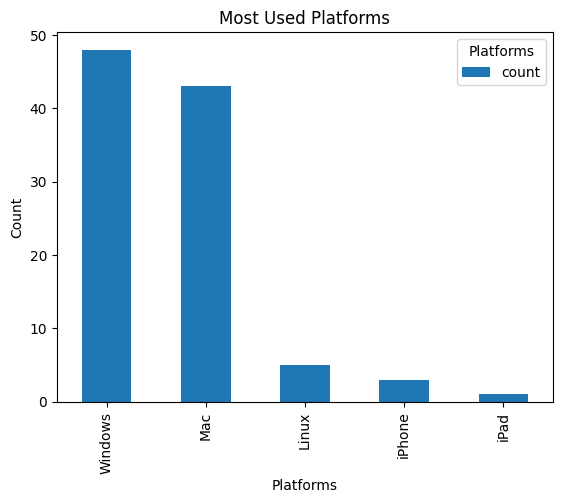

In [85]:
#### What platforms are most used per timezone?
platform_overall=omega_raw.groupby('userId')['userAgent'].first().value_counts()
platform_est = est_df.groupby('userId')['userAgent'].first().value_counts()
platform_cst = cst_df.groupby('userId')['userAgent'].first().value_counts()
platform_mst = mst_df.groupby('userId')['userAgent'].first().value_counts()
platform_pst = pst_df.groupby('userId')['userAgent'].first().value_counts()
platform_hast = hast_df.groupby('userId')['userAgent'].first().value_counts()
print(platform_overall)
############## Graph
ax = platform_overall.plot(kind='bar', stacked=True)
ax.set_xlabel("Platforms")
ax.set_ylabel("Count")
ax.set_title("Most Used Platforms")
plt.legend(title="Platforms")

plt.show()

level
free    83
paid    17
Name: count, dtype: int64


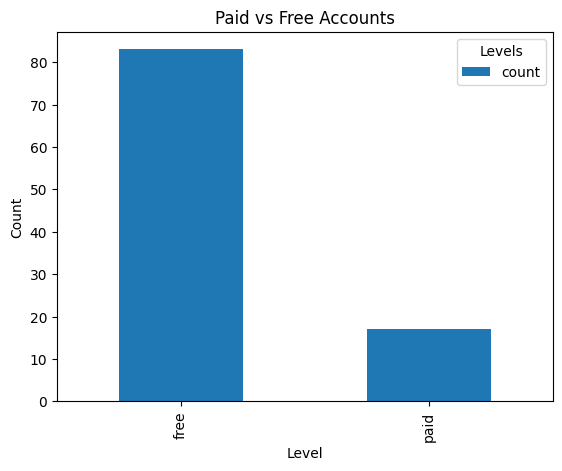

In [88]:
#### What Paid Level is most common per time zone?

overall_paid_level=omega_raw.groupby('userId')['level'].first().value_counts()
est_paid_level = est_df.groupby('userId')['level'].first().value_counts()
cst_paid_level = cst_df.groupby('userId')['level'].first().value_counts()
mst_paid_level = mst_df.groupby('userId')['level'].first().value_counts()
pst_paid_level = pst_df.groupby('userId')['level'].first().value_counts()
hast_paid_level= hast_df.groupby('userId')['level'].first().value_counts()
print(overall_paid_level)

################Graph
ax = overall_paid_level.plot(kind='bar', stacked=True)
ax.set_xlabel("Level")
ax.set_ylabel("Count")
ax.set_title("Paid vs Free Accounts")
plt.legend(title="Levels")

plt.show()

Unrefined TOTAL Average Hours IQR
3610.65
Refined PST Hours IQR
543.0
Unrefined PST Hours IQR
5386.42
Refined EST Hours IQR
2781.28
Unrefined EST Hours IQR
4102.5
Refined CST Hours IQR
4650.7
Unrefined CST Hours IQR
2033.06
Refined MST Hours IQR
543.0
Unrefined MST Hours IQR
4457.14
Unrefined HAST Hours IQR
7389.0
Refined Overall Hours IQR
3181.4


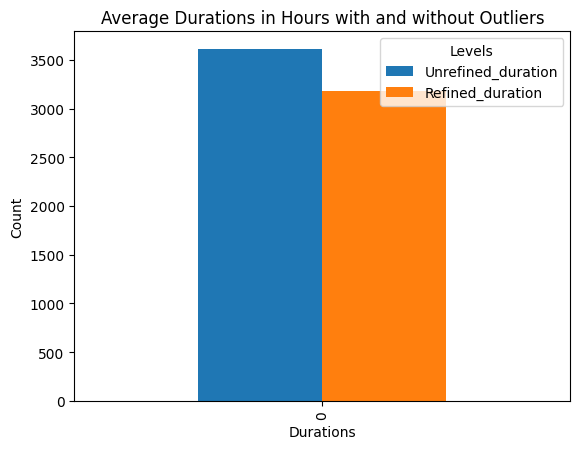

In [95]:
####### Average Hours Played per Time Zone ############
####Find outliers to make them toggle-able later

total_dur=omega_raw['duration'].sum()
total_uni=omega_raw['userId'].nunique()
total_dur=total_dur/total_uni
total_dur=total_dur.round(2)
print("Unrefined TOTAL Average Hours IQR")
print(total_dur)


############################################# PST

### Add duration for each unique User ID
pst_dur=pst_df.groupby('userId')['duration'].sum().sort_values(ascending=False)


### Find the outliers using IQR method
pst_q1 = pst_dur.quantile(0.25)
pst_q3 = pst_dur.quantile(0.75)
pst_IQR = pst_q3 - pst_q1
pst_no_outliers = pst_dur[(pst_q1 - 1.5*pst_IQR < pst_dur) &  (pst_dur < pst_q3 + 1.5*pst_IQR)]


### Use the filter to give average duration with and without outliers

## Turn Series into DF and give the index
dfpst_no_outliers=pd.DataFrame(pst_no_outliers)
dfpst_no_outliers=dfpst_no_outliers.reset_index(drop=False)

## Filter data by outliers and non outliers.
##### Refined
pst_refined_sum=dfpst_no_outliers['duration'].sum()
pst_reuni=dfpst_no_outliers['userId'].nunique()
pst_refined_av=pst_refined_sum/pst_reuni
pst_refined_av=pst_refined_av.round(2)
print("Refined PST Hours IQR")
print(pst_refined_av)

##### Unrefined
pst_allin_dur=pst_df['duration'].sum()
pst_uni=pst_df['userId'].nunique()
pst_allin_dur=pst_allin_dur/pst_uni
pst_allin_dur=pst_allin_dur.round(2)
print("Unrefined PST Hours IQR")
print(pst_allin_dur)

############################################# EST

### Add duration for each unique User ID
est_dur=est_df.groupby('userId')['duration'].sum().sort_values(ascending=False)


### Find the outliers using IQR method
est_q1 = est_dur.quantile(0.25)
est_q3 = est_dur.quantile(0.75)
est_IQR = est_q3 - est_q1
est_no_outliers = est_dur[(est_q1 - 1.5*est_IQR < est_dur) &  (est_dur < est_q3 + 1.5*est_IQR)]


### Use the filter to give average duration with and without outliers

## Turn Series into DF and give the index
dfest_no_outliers=pd.DataFrame(est_no_outliers)
dfest_no_outliers=dfest_no_outliers.reset_index(drop=False)

## Filter data by outliers and non outliers.
##### Refined
est_refined_sum=dfest_no_outliers['duration'].sum()
est_reuni=dfest_no_outliers['userId'].nunique()
est_refined_av=est_refined_sum/est_reuni
est_refined_av=est_refined_av.round(2)
print("Refined EST Hours IQR")
print(est_refined_av)

##### Unrefined
est_allin_dur=est_df['duration'].sum()
est_uni=est_df['userId'].nunique()
est_allin_dur=est_allin_dur/est_uni
est_allin_dur=est_allin_dur.round(2)
print("Unrefined EST Hours IQR")
print(est_allin_dur)

########################################## CST

### Add duration for each unique User ID
cst_dur=cst_df.groupby('userId')['duration'].sum().sort_values(ascending=False)


### Find the outliers using IQR method
cst_q1 = cst_dur.quantile(0.25)
cst_q3 = cst_dur.quantile(0.75)
cst_IQR = cst_q3 - cst_q1
cst_no_outliers = cst_dur[(cst_q1 - 1.5*cst_IQR < cst_dur) &  (cst_dur < cst_q3 + 1.5*cst_IQR)]


### Use the filter to give average duration with and without outliers

## Turn Series into DF and give the index
dfcst_no_outliers=pd.DataFrame(cst_no_outliers)
dfcst_no_outliers=dfcst_no_outliers.reset_index(drop=False)

## Filter data by outliers and non outliers.
##### Refined
cst_refined_sum=dfcst_no_outliers['duration'].sum()
cst_reuni=dfpst_no_outliers['userId'].nunique()
cst_refined_av=cst_refined_sum/cst_reuni
cst_refined_av=cst_refined_av.round(2)
print("Refined CST Hours IQR")
print(cst_refined_av)

##### Unrefined
cst_allin_dur=cst_df['duration'].sum()
cst_uni=cst_df['userId'].nunique()
cst_allin_dur=cst_allin_dur/cst_uni
cst_allin_dur=cst_allin_dur.round(2)
print("Unrefined CST Hours IQR")
print(cst_allin_dur)

########################################## MST

### Add duration for each unique User ID
mst_dur=pst_df.groupby('userId')['duration'].sum().sort_values(ascending=False)


### Find the outliers using IQR method
mst_q1 = mst_dur.quantile(0.25)
mst_q3 = mst_dur.quantile(0.75)
mst_IQR = mst_q3 - mst_q1
mst_no_outliers = mst_dur[(mst_q1 - 1.5*mst_IQR < mst_dur) &  (mst_dur < mst_q3 + 1.5*mst_IQR)]


### Use the filter to give average duration with and without outliers

## Turn Series into DF and give the index
dfmst_no_outliers=pd.DataFrame(mst_no_outliers)
dfmst_no_outliers=dfmst_no_outliers.reset_index(drop=False)

## Filter data by outliers and non outliers.
##### Refined
mst_refined_sum=dfmst_no_outliers['duration'].sum()
mst_reuni=dfmst_no_outliers['userId'].nunique()
mst_refined_av=mst_refined_sum/mst_reuni
mst_refined_av=mst_refined_av.round(2)
print("Refined MST Hours IQR")
print(mst_refined_av)

##### Unrefined
mst_allin_dur=mst_df['duration'].sum()
mst_uni=mst_df['userId'].nunique()
mst_allin_dur=mst_allin_dur/mst_uni
mst_allin_dur=mst_allin_dur.round(2)
print("Unrefined MST Hours IQR")
print(mst_allin_dur)

########################################## HAST

### Add duration for each unique User ID
hast_dur=hast_df.groupby('userId')['duration'].sum().sort_values(ascending=False)


### Find the outliers using IQR method
## Only 1 HAST user as of right now. Will turn back on when data pool grows


# hast_q1 = hast_dur.quantile(0.25)
# hast_q3 = hast_dur.quantile(0.75)
# hast_IQR = hast_q3 - hast_q1
# hast_no_outliers = hast_dur[(hast_q1 - 1.5*hast_IQR < hast_dur) &  (hast_dur < hast_q3 + 1.5*hast_IQR)]


# ### Use the filter to give average duration with and without outliers

# ## Turn Series into DF and give the index
# dfhast_no_outliers=pd.DataFrame(hast_no_outliers)
# dfhast_no_outliers=dfhast_no_outliers.reset_index(drop=False)

# ## Filter data by outliers and non outliers.
# ##### Refined
# hast_refined_sum=dfhast_no_outliers['duration'].sum()
# hast_reuni=dfhast_no_outliers['userId'].nunique()
# hast_refined_av=hast_refined_sum/hast_reuni
# hast_refined_av=hast_refined_av.round(2)
# print("Refined HAST Hours IQR")
# print(hast_refined_av)

##### Unrefined
hast_allin_dur=hast_df['duration'].sum()
hast_uni=hast_df['userId'].nunique()
hast_allin_dur=hast_allin_dur/hast_uni
hast_allin_dur=hast_allin_dur.round(2)
print("Unrefined HAST Hours IQR")
print(hast_allin_dur)

refin_overall_dur = est_refined_av + cst_refined_av + mst_refined_av + pst_refined_av + hast_allin_dur
refin_overall_dur = refin_overall_dur/5
refin_overall_dur = refin_overall_dur.round(2)
print("Refined Overall Hours IQR")
print(refin_overall_dur)

overall_refin_andallin_dur=pd.DataFrame({'Unrefined_duration': [total_dur], 'Refined_duration': [refin_overall_dur]})

ax = overall_refin_andallin_dur.plot(kind='bar')
ax.set_xlabel("Durations")
ax.set_ylabel("Count")
ax.set_title("Average Durations in Hours with and without Outliers")
plt.legend(title="Levels")

plt.show()